In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder

from sklearn import tree
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import RandomForestRegressor
import os
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from skfeature.function.similarity_based import fisher_score
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy as bp

In [4]:
# os.chdir("C:/Users/micha/OneDrive/Dokumenty/GitHub/Machine_Learning_Regression/Machine_Learning_Regression")

df = pd.read_csv('../data/output/df_train.csv', index_col=0)
df_test = pd.read_csv('../data/output/df_test.csv', index_col=0)


df.sample(10)

,mother_body_mass_index,mother_marital_status,mother_delivery_weight,mother_race,mother_height,mother_weight_gain,father_age,father_education,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,newborn_gender,newborn_weight
1853761,30.4,1.0,227.0,1,67.0,33.0,37.0,6,0.0,2,12.0,N,M,3629
1898231,38.5,1.0,229.0,2,61.0,25.0,42.0,7,0.0,6,9.0,N,F,3997
489823,20.4,2.0,195.0,3,64.0,76.0,22.0,3,0.0,2,15.0,N,F,3232
723593,24.3,1.0,202.0,1,62.0,69.0,29.0,6,0.0,2,11.0,N,M,2968
1009985,51.1,0.0,317.0,1,64.0,19.0,32.0,3,0.0,3,19.0,N,F,3714
655604,24.7,2.0,182.0,1,67.0,24.0,32.0,9,0.0,2,8.0,N,F,3147
334967,35.9,2.0,193.0,1,61.0,3.0,32.0,9,0.0,2,11.0,Y,F,2570
880694,31.2,1.0,186.0,1,63.0,10.0,32.0,4,0.0,2,12.0,Y,F,2656
1446171,33.7,1.0,200.0,2,63.0,10.0,34.0,4,0.0,5,6.0,Y,F,1112
1820715,35.4,1.0,198.0,2,63.0,0.0,35.0,7,0.0,4,14.0,Y,M,3374


## Transforming variables

Delete maybe weight, use more of the weight gain, may be more important. USE BMI, we can factorise it
Need to hot encode:
* mother_marital_status
* mother_race
* father_education
* parental_care_month
* previous_cesarean
* newborn_gender

In [5]:
def quick_viz(x):
    # create a figure with a histogram of x
    plt.figure(figsize=(10, 5))
    sns.histplot(data=x, kde=False, bins=50)
    plt.plot()

    # create a figure with a boxplot of x
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=x)
    plt.plot()

    # create a figure with a scatterplot of x and df.etr
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=df['newborn_weight'])
    plt.plot()

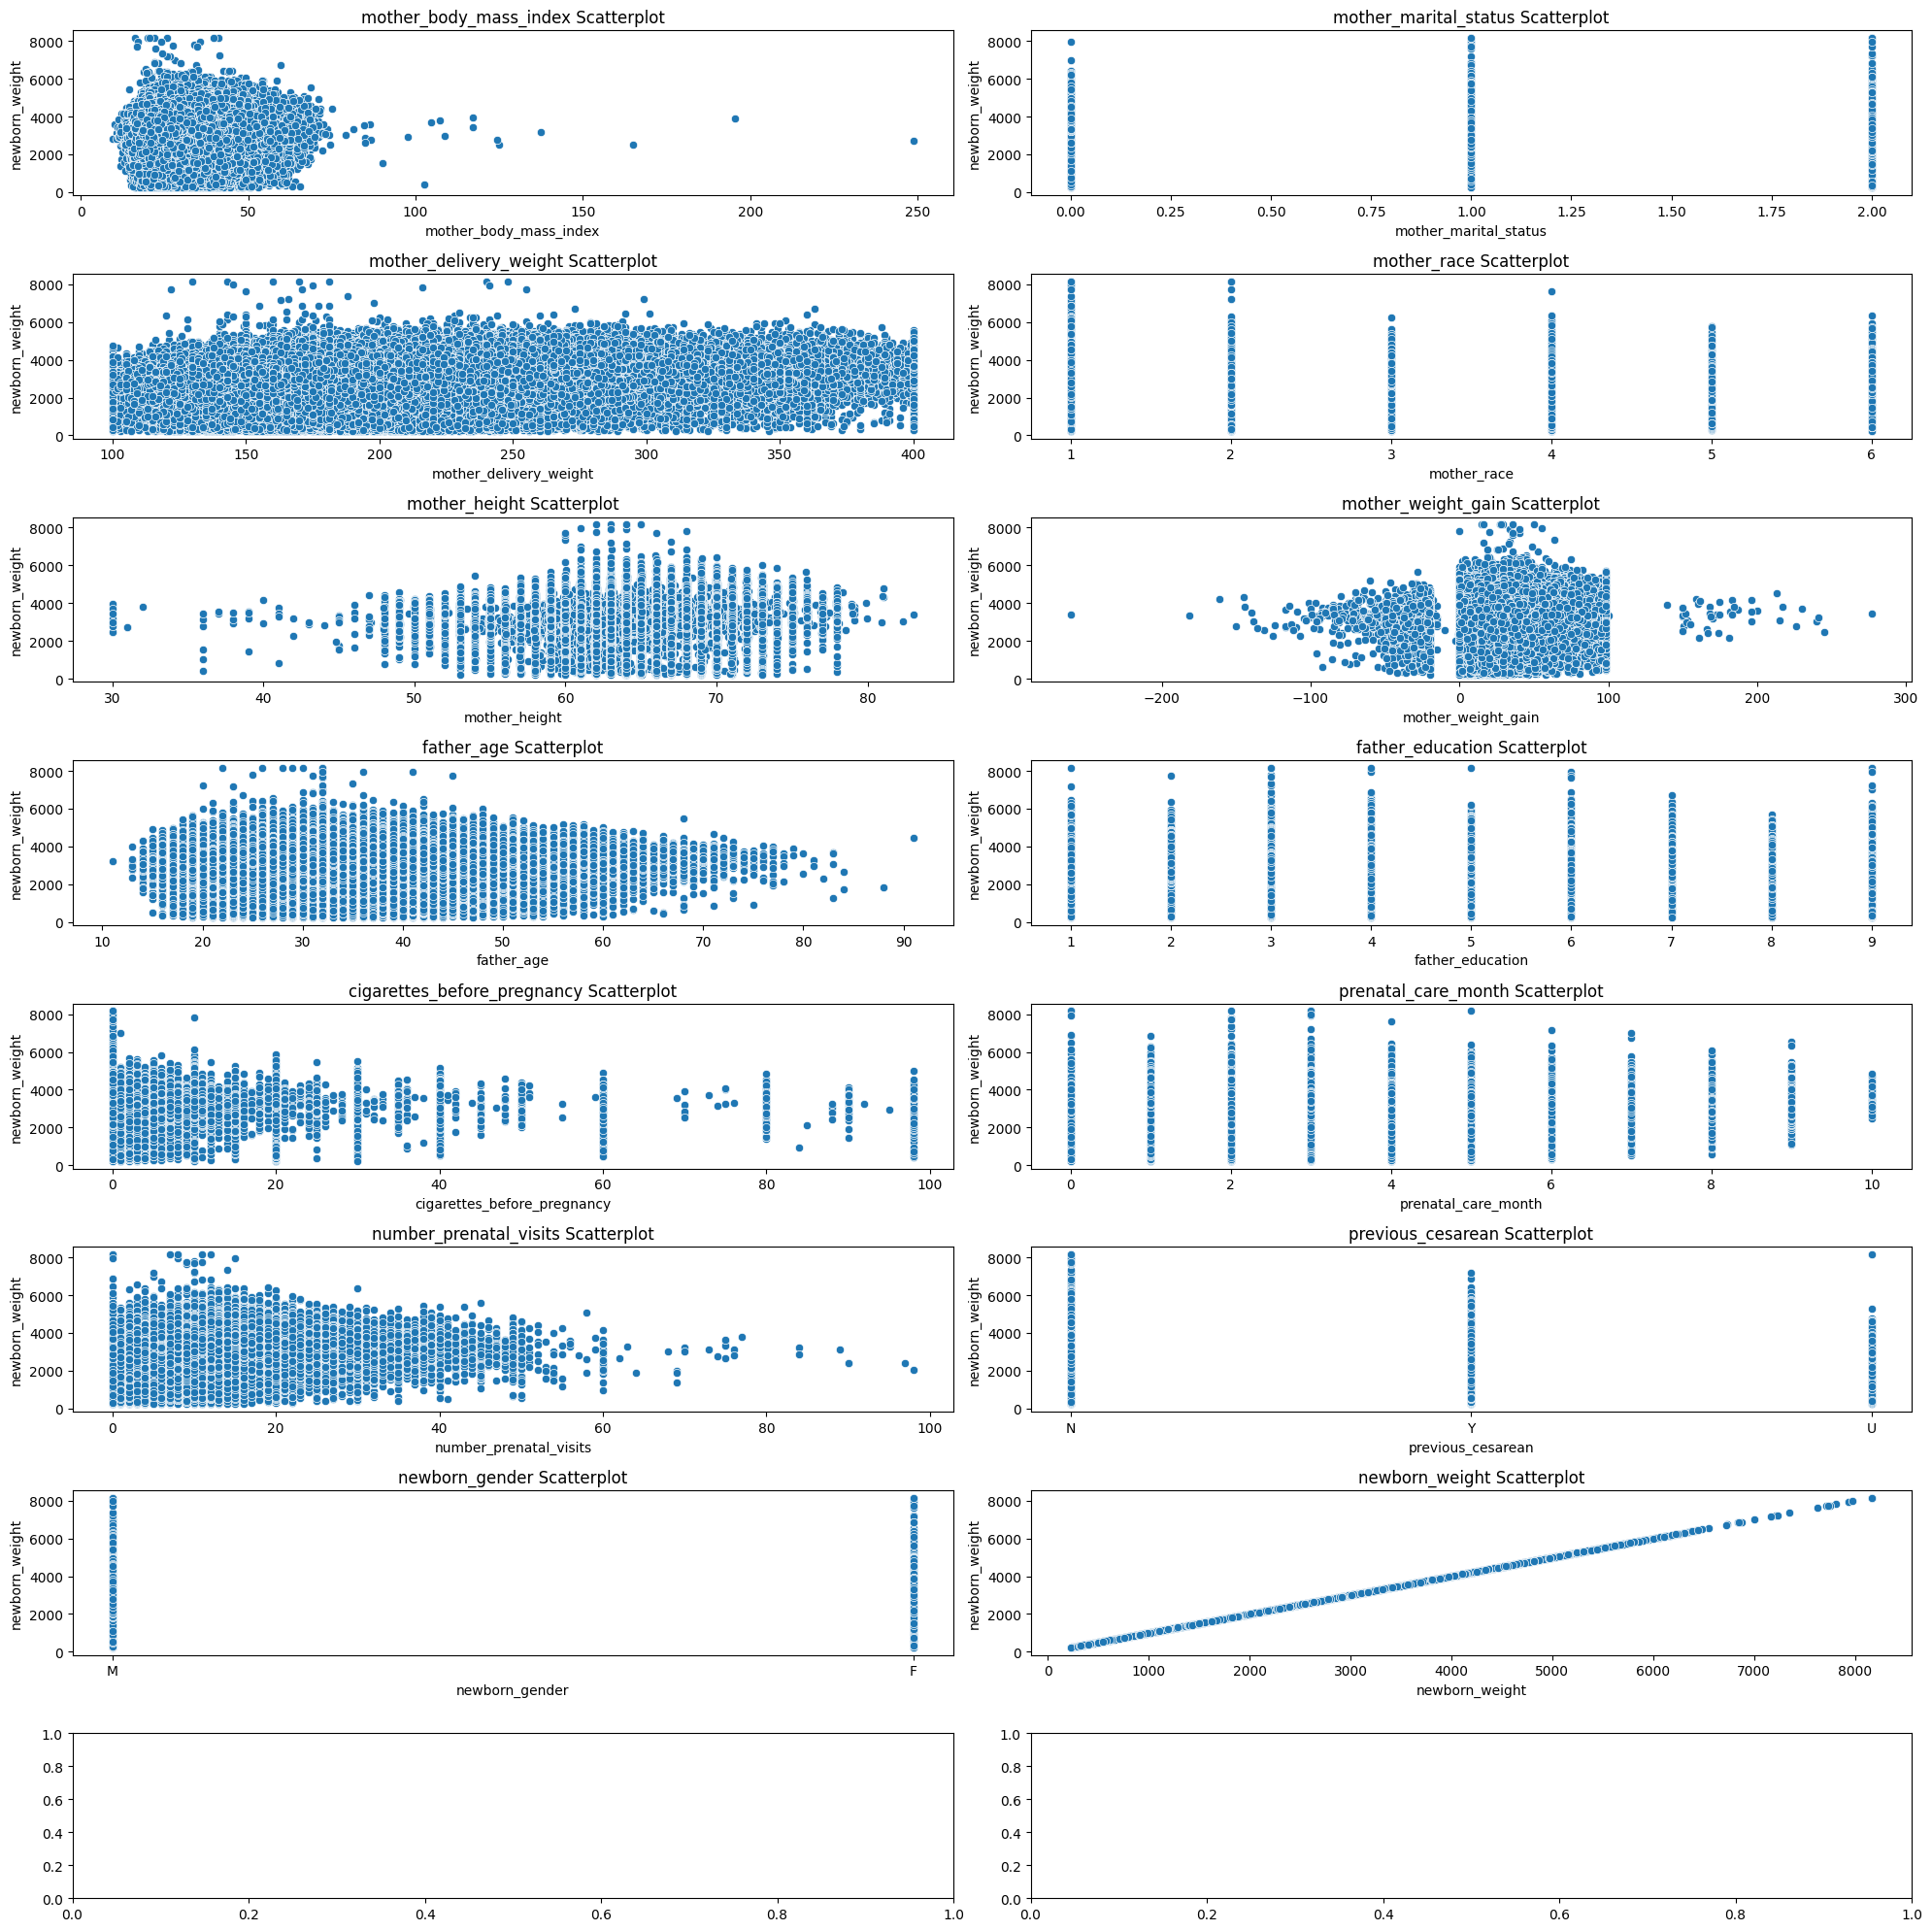

In [6]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

columns = df.columns

for i, column in enumerate(columns):

    ax = axes[i]
    sns.scatterplot(data=df, x=column, y='newborn_weight', ax=ax)
    ax.set_title(column + " Scatterplot")
    ax.set_xlabel(column)
    ax.set_ylabel("newborn_weight")

plt.tight_layout()
plt.show()

### Deleting outliers

Log Transformation & Deleting outliers

In [7]:
df.loc[df['mother_body_mass_index'] > 80, 'mother_body_mass_index'] = 80
df.loc[df['number_prenatal_visits'] > 60, 'number_prenatal_visits'] = 60
df.loc[df['father_age'] > 80, 'father_age'] = 80
df.loc[df['mother_height'] < 45, 'mother_height'] = 45
df['mother_delivery_weight_log'] = np.log(df['mother_delivery_weight'])
df['mother_body_mass_index_log'] = np.log(df['mother_body_mass_index'])

### Hot encoding

In [8]:
def feature_engineering(df):

    df.loc[df['mother_body_mass_index'] > 80, 'mother_body_mass_index'] = 80
    df.loc[df['number_prenatal_visits'] > 60, 'number_prenatal_visits'] = 60
    df.loc[df['father_age'] > 80, 'father_age'] = 80
    df.loc[df['mother_height'] < 45, 'mother_height'] = 45
    df['mother_delivery_weight'] = np.log(df['mother_delivery_weight'])
    df['mother_body_mass_index'] = np.log(df['mother_body_mass_index'])

    df = pd.get_dummies(df, columns=['mother_marital_status'], drop_first=True)
    df.rename(columns={'mother_marital_status_1.0': 'mother_marital_status_married', 
              'mother_marital_status_2.0': 'mother_marital_status_not_married'}, inplace=True)
    df['mother_marital_status_married'] = df['mother_marital_status_married'].astype(bool)
    df['mother_marital_status_not_married'] = df['mother_marital_status_not_married'].astype(bool)
    
    race_mapping = {
        2: 'Black',
        3: 'AIAN',
        4: 'Asian',
        5: 'NHOPI',
        6: '>1_race'
    }

    df = pd.get_dummies(df, columns=['mother_race'], drop_first=True)
    df.rename(columns={f"mother_race_{i}": race_mapping[i] for i in race_mapping.keys()}, inplace=True)
    df['Black'] = df['Black'].astype(bool)
    df['AIAN'] = df['AIAN'].astype(bool)
    df['Asian'] = df['Asian'].astype(bool)
    df['NHOPI'] = df['NHOPI'].astype(bool)
    df['>1_race'] = df['>1_race'].astype(bool)


    education_mapping = {
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 2,
        6: 3,
        7: 3,
        8: 4,
        9: 0
    }
    df['father_education'] = df['father_education'].map(education_mapping)

    #df['prenatal_care_month'] = df['prenatal_care_month'].replace([1, 2, 3], 1)
    #df['prenatal_care_month'] = df['prenatal_care_month'].replace([4, 5, 6], 2)
    #df['prenatal_care_month'] = df['prenatal_care_month'].replace([7, 8, 9, 10], 3)
    #encoded_columns = pd.get_dummies(df['prenatal_care_month'], prefix='prenatal_care')
    #encoded_columns.columns = encoded_columns.columns.str.replace('prenatal_care_', 'prenatal_care_')
    #df = pd.concat([df, encoded_columns], axis=1)

    df['previous_cesarean'] = df['previous_cesarean'].map({'Y': 1, 'N': 0, 'U': 0}).astype(bool)

    df['newborn_gender'] = (df['newborn_gender'] == 'M').astype(bool)

    df['smoker'] =(df['cigarettes_before_pregnancy'] > 0).astype(bool)
    

    return df



In [9]:
df_test = feature_engineering(df_test)
df = feature_engineering(df)

In [10]:
df = df.reset_index(drop=True)


In [11]:
num_missing = df.isna().sum()
num_missing = num_missing[num_missing > 0]

percent_missing = num_missing * 100 / df.shape[0]
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)


,Missing Values,Percentage


In [12]:
#quick_viz(df['mother_body_mass_index'])

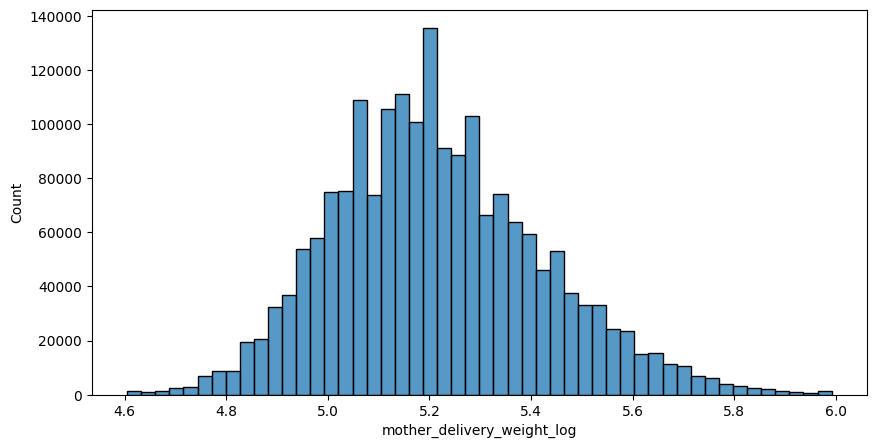

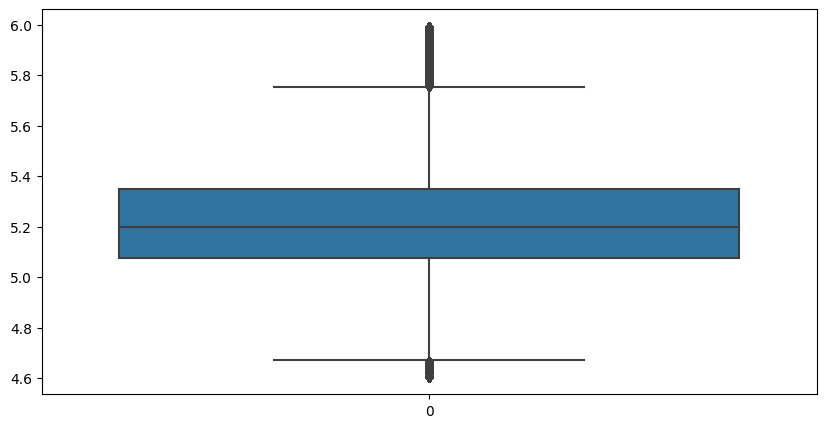

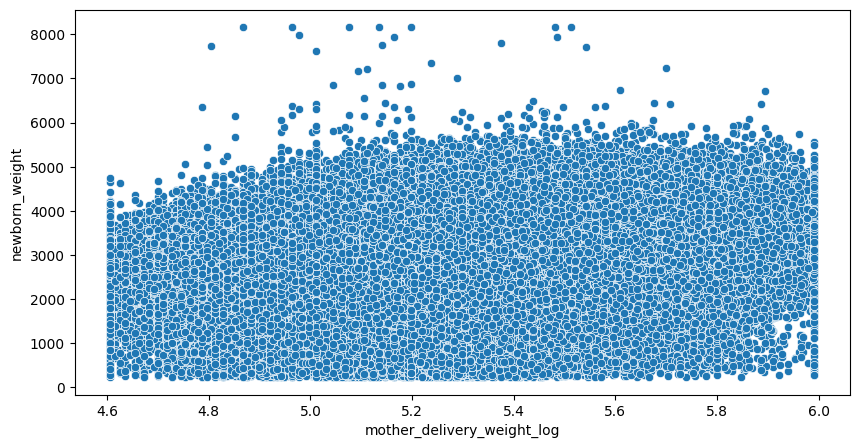

In [13]:
quick_viz(df['mother_delivery_weight_log'])

## Feature Selection

### Sampling the data

In [14]:
df.columns

Index(['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'father_education',
       'cigarettes_before_pregnancy', 'prenatal_care_month',
       'number_prenatal_visits', 'previous_cesarean', 'newborn_gender',
       'newborn_weight', 'mother_delivery_weight_log',
       'mother_body_mass_index_log', 'mother_marital_status_married',
       'mother_marital_status_not_married', 'Black', 'AIAN', 'Asian', 'NHOPI',
       '>1_race', 'smoker'],
      dtype='object')

In [15]:
y_col = ['newborn_weight']

In [16]:
x_col = ['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'father_education',
       'cigarettes_before_pregnancy', 'prenatal_care_month',
       'number_prenatal_visits', 'previous_cesarean', 'newborn_gender',
       'mother_delivery_weight_log',
       'mother_body_mass_index_log', 'mother_marital_status_married',
       'mother_marital_status_not_married', 'Black', 'AIAN', 'Asian', 'NHOPI',
       '>1_race', 'smoker']

In [17]:
df = df.sample(n=500000, random_state=42)
df = df.reset_index(drop=True)

In [18]:
scaler = MinMaxScaler()
df_re = pd.DataFrame(scaler.fit_transform(df.loc[:, x_col]), columns = x_col)

In [19]:
df_re = pd.DataFrame(StandardScaler().fit_transform(df.loc[:, x_col]), columns=x_col)


In [20]:
#df = df.drop('newborn_weight', axis=1)
df = pd.concat([df_re, df[y_col]], axis=1)

In [21]:
df.columns

Index(['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'father_education',
       'cigarettes_before_pregnancy', 'prenatal_care_month',
       'number_prenatal_visits', 'previous_cesarean', 'newborn_gender',
       'mother_delivery_weight_log', 'mother_body_mass_index_log',
       'mother_marital_status_married', 'mother_marital_status_not_married',
       'Black', 'AIAN', 'Asian', 'NHOPI', '>1_race', 'smoker',
       'newborn_weight'],
      dtype='object')

In [22]:
df['newborn_weight']

0         2745
1         4595
2         2314
3         3375
4         2745
          ... 
499995    2000
499996    3216
499997    2810
499998    3997
499999    3830
Name: newborn_weight, Length: 500000, dtype: int64

In [23]:
df.dtypes

mother_body_mass_index               float64
mother_delivery_weight               float64
mother_height                        float64
mother_weight_gain                   float64
father_age                           float64
father_education                     float64
cigarettes_before_pregnancy          float64
prenatal_care_month                  float64
number_prenatal_visits               float64
previous_cesarean                    float64
newborn_gender                       float64
mother_delivery_weight_log           float64
mother_body_mass_index_log           float64
mother_marital_status_married        float64
mother_marital_status_not_married    float64
Black                                float64
AIAN                                 float64
Asian                                float64
NHOPI                                float64
>1_race                              float64
smoker                               float64
newborn_weight                         int64
dtype: obj

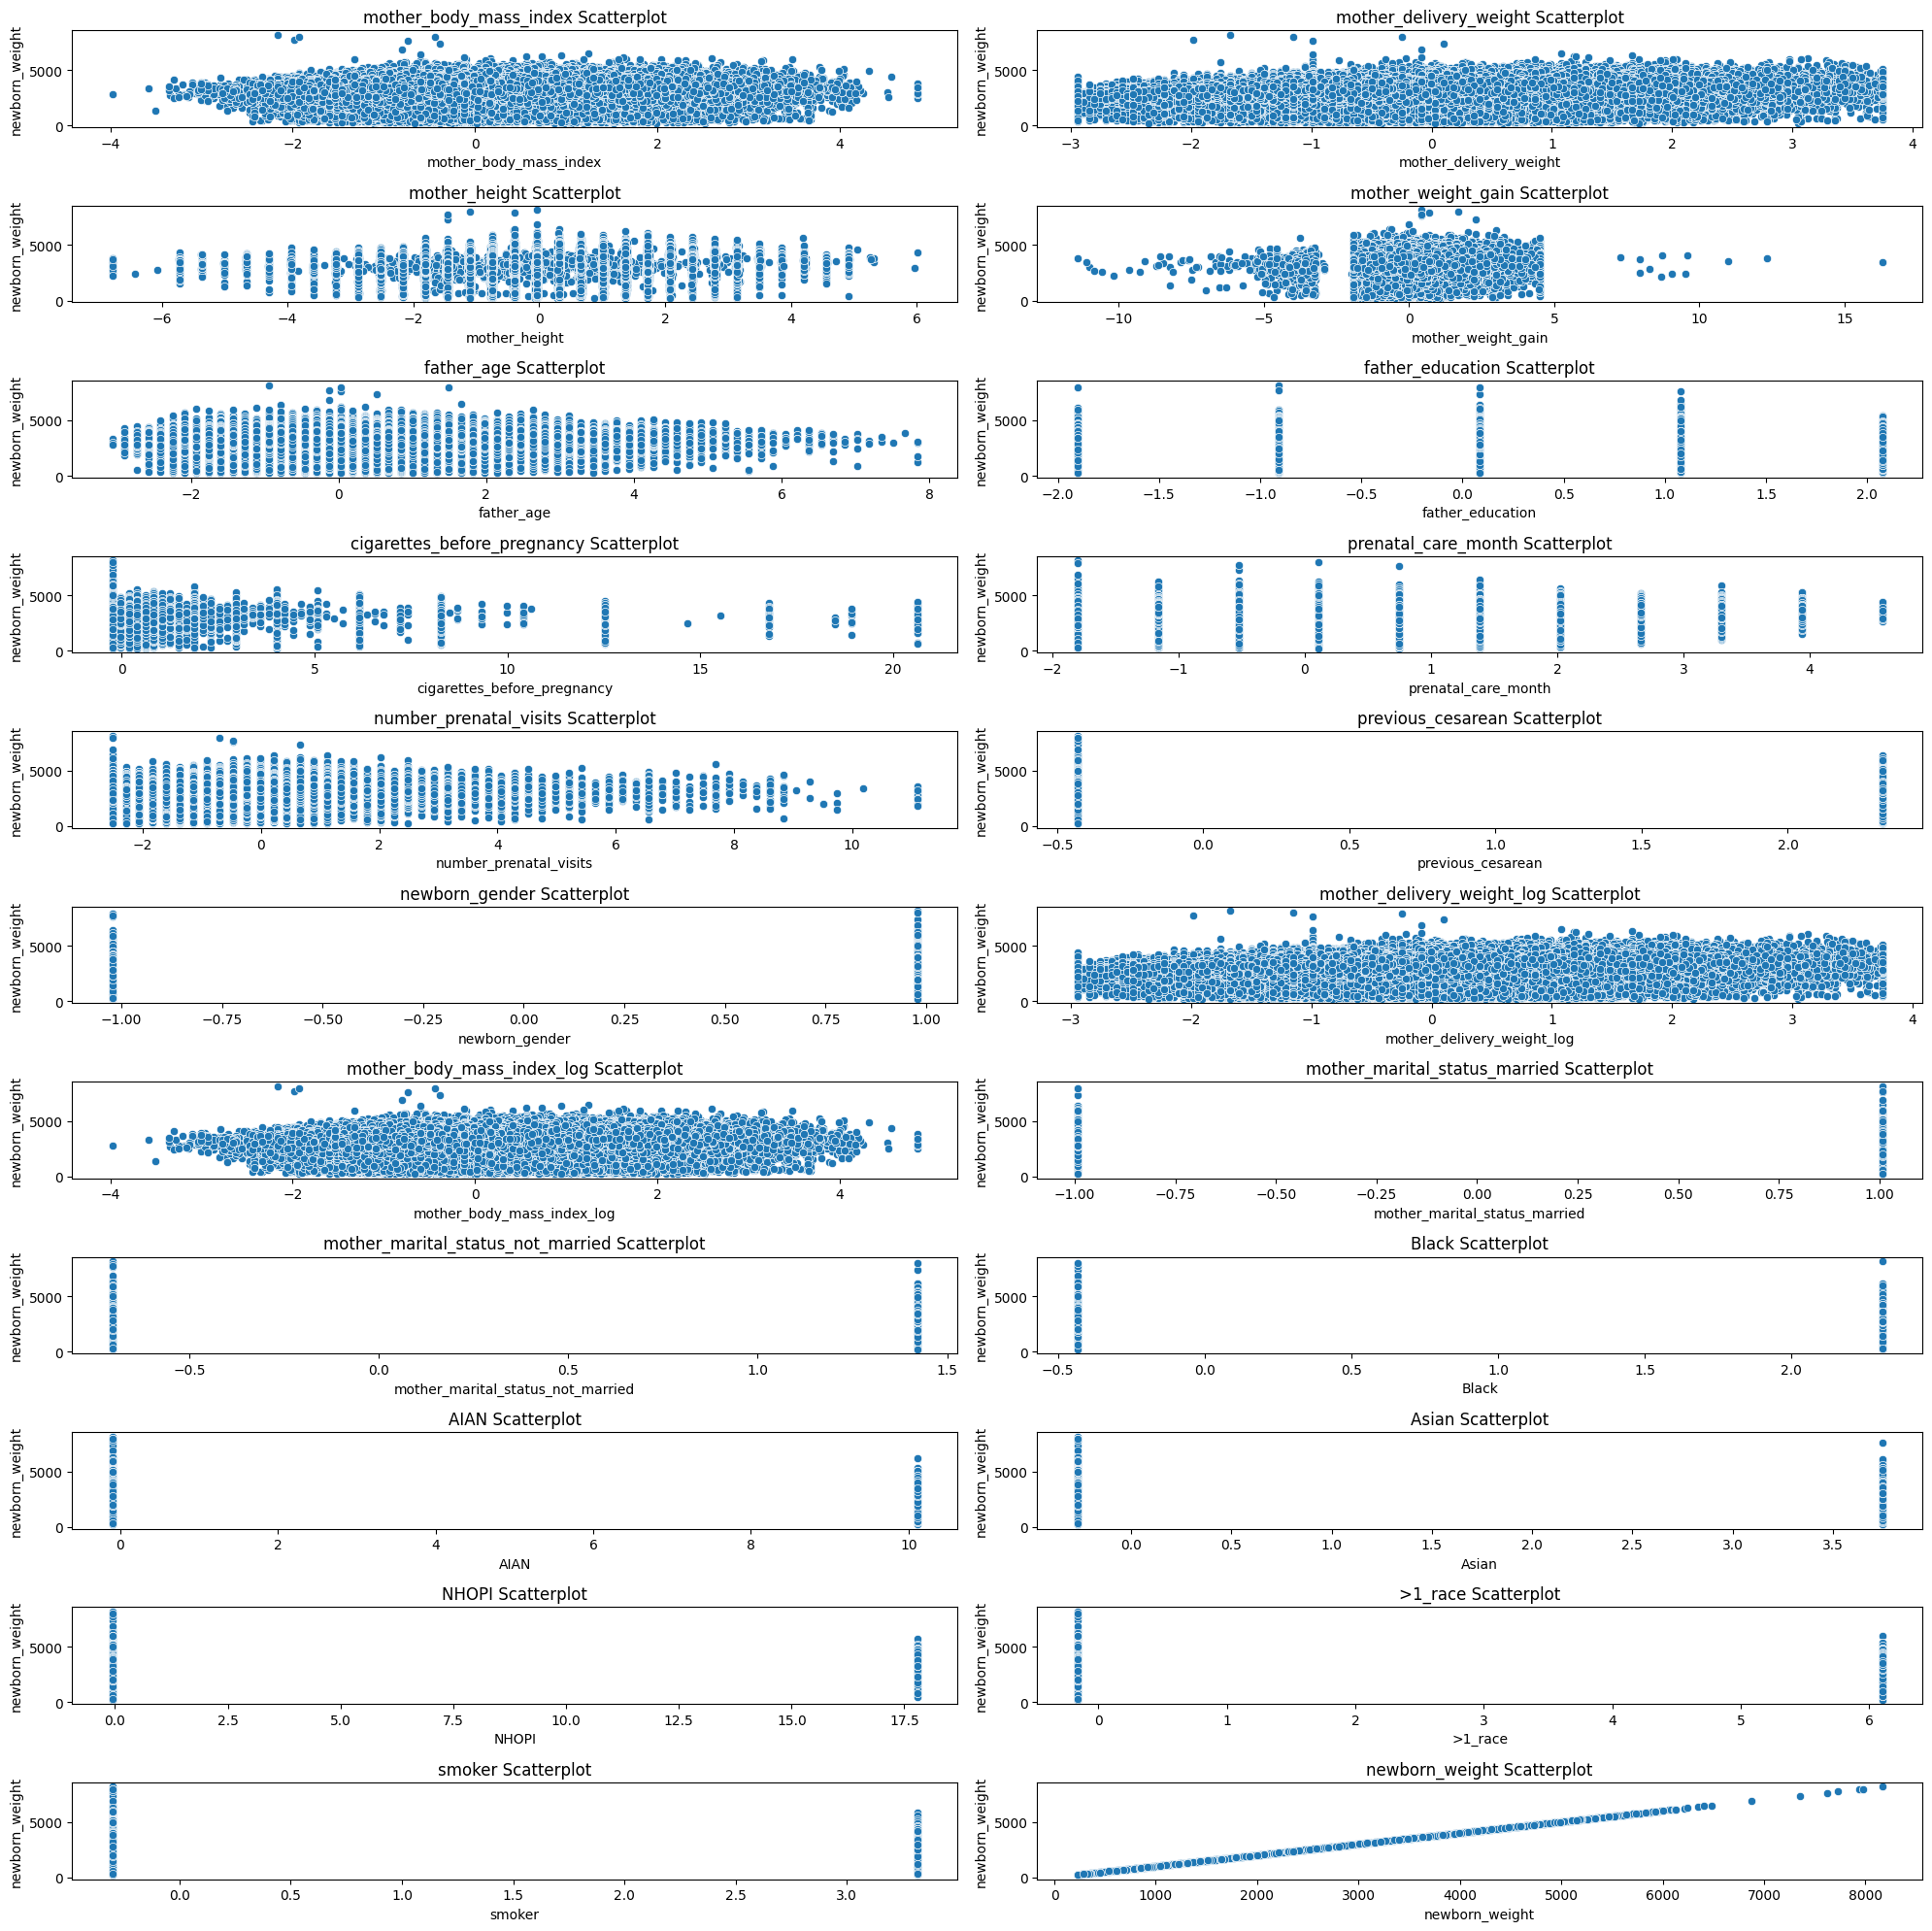

In [24]:
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

columns = df.columns

for i, column in enumerate(columns):

    ax = axes[i]
    sns.scatterplot(data=df, x=column, y='newborn_weight', ax=ax)
    ax.set_title(column + " Scatterplot")
    ax.set_xlabel(column)
    ax.set_ylabel("newborn_weight")

plt.tight_layout()
plt.show()

In [25]:
sel = VarianceThreshold(0.001)
sel_var = sel.fit_transform(df[x_col])
col_imp = df[x_col][df[x_col].columns[sel.get_support(indices=True)]].columns
col_redundant = set(df[x_col].columns.tolist()) - set(col_imp)


In [26]:
general_ranking = pd.DataFrame(index=x_col)

In [27]:
#sel_ = SelectFromModel(Lasso(alpha=0.005, random_state=10))
#sel_.fit(df[x_col], df[y_col])
#sel_.get_feature_names_out()

## Correlation

<Axes: >

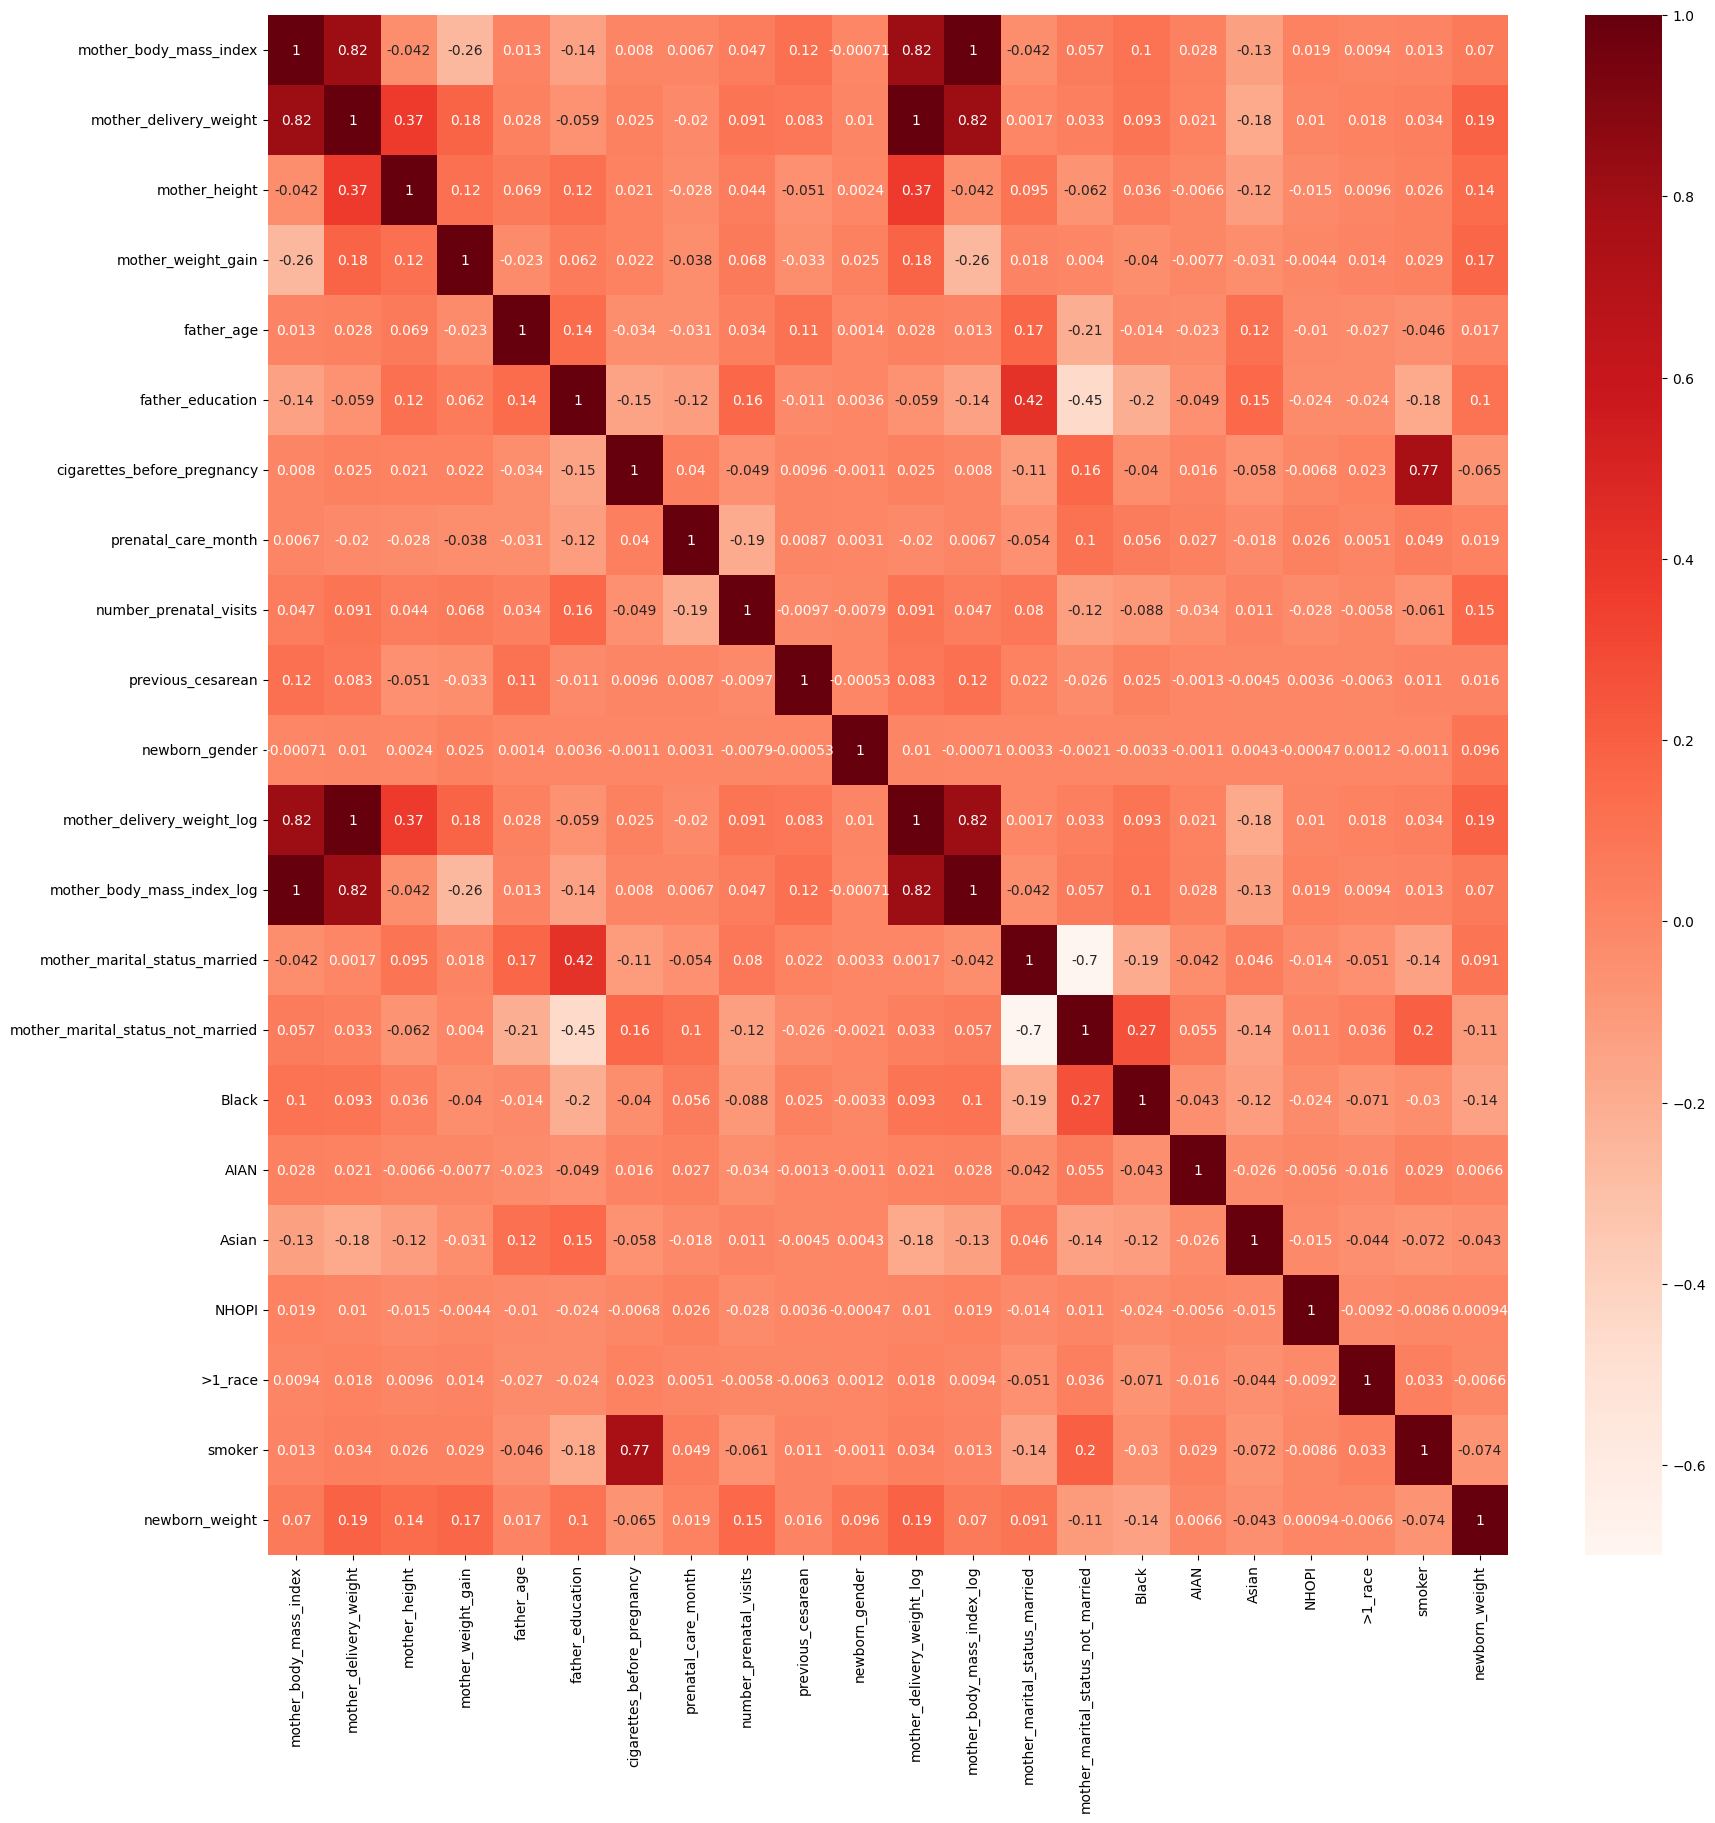

In [28]:
cor = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

### Mutual information

In [29]:
mi = dict()
for i in x_col:
    mi.update({i: mutual_info_regression(df[[i]].values, df[y_col].values.ravel())[0]})

In [30]:
miDF = pd.DataFrame.from_dict(mi, orient="index", columns=["score"])

In [31]:
miDF.sort_values(by="score").head(10)

,score
AIAN,0.000000
NHOPI,0.000224
previous_cesarean,0.000800
>1_race,0.001641
Asian,0.002027
smoker,0.003857
cigarettes_before_pregnancy,0.004470
father_age,0.005487
mother_marital_status_married,0.006084
prenatal_care_month,0.006209


In [32]:
miDF.sort_values(by="score", ascending=False).head(10)

,score
mother_delivery_weight_log,0.037486
mother_delivery_weight,0.036013
number_prenatal_visits,0.025584
mother_weight_gain,0.019292
mother_height,0.015939
mother_body_mass_index,0.011893
mother_body_mass_index_log,0.010882
Black,0.010849
father_education,0.008544
newborn_gender,0.007798


In [33]:
general_ranking = pd.merge(general_ranking, miDF, left_index=True, right_index=True)
general_ranking.rename(columns={"score": "mi_score"}, inplace=True)

### F-score

In [34]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
fscore = dict()
for i in x_col:
    fscore.update({i: f_regression(df[[i]].values, df[y_col].values.ravel())[1]})

In [35]:
fscoreDF = pd.DataFrame.from_dict(fscore, orient="index", columns=["p_value_score"])
fscoreDF.sort_values(by="p_value_score").head(10)

,p_value_score
mother_body_mass_index,0.0
Black,0.0
mother_marital_status_not_married,0.0
mother_marital_status_married,0.0
mother_body_mass_index_log,0.0
mother_delivery_weight_log,0.0
number_prenatal_visits,0.0
newborn_gender,0.0
cigarettes_before_pregnancy,0.0
father_education,0.0


In [36]:
fscoreDF.sort_values(by="p_value_score", ascending=False).head(10)

,p_value_score
NHOPI,5.068211e-01
>1_race,2.623715e-06
AIAN,2.590617e-06
previous_cesarean,2.419106e-28
father_age,2.633871e-33
prenatal_care_month,2.695165e-39
Asian,2.574121e-206
mother_body_mass_index,0.000000e+00
mother_body_mass_index_log,0.000000e+00
Black,0.000000e+00


In [37]:
general_ranking = pd.merge(general_ranking, fscoreDF, left_index=True, right_index=True)

In [38]:
general_ranking.rename(
    columns={"p_value_score": "sign_fscore", "sign": "sign_fscore_0_1"}, inplace=True
)

### Boruta

In [39]:
rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
feat_selector = bp(rf, n_estimators="auto", verbose=2)


In [40]:
feat_selector.fit_transform(df.loc[:, x_col].values, df.loc[:, y_col].values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	6
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	6
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	6
Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	7
I

array([[-0.11701391, -0.21682231, -0.04345244, ..., -0.70381385,
        -0.43320688, -0.30150477],
       [ 0.64655118,  0.3517935 , -0.04345244, ...,  1.42083024,
        -0.43320688, -0.30150477],
       [-1.23614235, -0.44140487,  1.75074789, ...,  1.42083024,
         2.30836591, -0.30150477],
       ...,
       [-0.69884968, -1.25311184, -1.46217452, ..., -0.70381385,
        -0.43320688, -0.30150477],
       [ 1.54792291,  1.77705845,  1.02058911, ..., -0.70381385,
        -0.43320688, -0.30150477],
       [-0.49000069, -0.41275402,  0.64727453, ..., -0.70381385,
        -0.43320688, -0.30150477]])

In [54]:
feat_selector.ranking_

array([1, 1, 1, 1, 4, 3, 1, 1, 1, 7, 1, 1, 1, 2, 1, 1, 7, 7, 7, 7, 1])

In [55]:
boruta_DF = pd.DataFrame(index=x_col)
boruta_DF["boruta_rank"] = feat_selector.ranking_

In [56]:
general_ranking = pd.merge(
    general_ranking, boruta_DF, left_index=True, right_index=True, how="left"
)

### ElasticNet

In [57]:
#scaler = StandardScaler()
#df.loc[:, df.columns != 'newborn_weight'] = scaler.fit_transform(
#    df.loc[:, df.columns != 'newborn_weight'])

In [58]:
def mape_cv(model, df):
    mape = cross_val_score(
            model,
            df.loc[:, x_col],
            df.loc[:, y_col],
            scoring='neg_mean_absolute_percentage_error',
            cv=5,
    )
    return mape

In [59]:
alphas = [0.0001, 0.001, 0.01, 0.03]
l1_ratios = [1,0.8, 0.5, 0.3, 0.1]

In [47]:
cv_elastic = [
    mape_cv(ElasticNet(alpha=alpha, l1_ratio=l1_ratio, tol = 0.5), df).mean()
    for (alpha, l1_ratio) in product(alphas, l1_ratios)
]

Text(0, 0.5, 'mape')

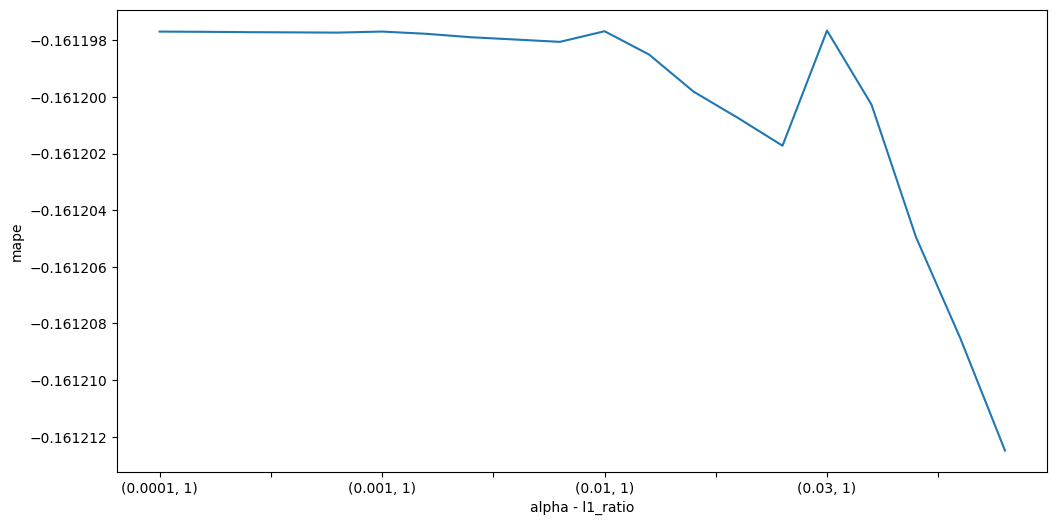

In [60]:
plt.rcParams["figure.figsize"] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index=idx)
p_cv_elastic.plot()
plt.xlabel("alpha - l1_ratio")
plt.ylabel("mape")

In [61]:
cv_elastic

[-0.16119769368839115,
 -0.16119770167767827,
 -0.1611977136629582,
 -0.16119772165516322,
 -0.1611977296529656,
 -0.16119769250652377,
 -0.16119777253911866,
 -0.16119789336653825,
 -0.16119797464160746,
 -0.1611980563564233,
 -0.16119768103210125,
 -0.16119850318003898,
 -0.16119981357259738,
 -0.16120074463473744,
 -0.1612017247557633,
 -0.1611976580471866,
 -0.16120027350851068,
 -0.1612049553022486,
 -0.1612085430496764,
 -0.1612124938836638]

In [62]:
def run_elastic_net(sample_1):
    elastic = ElasticNet(alpha=1, l1_ratio=0.5)
    elastic.fit(sample_1.loc[:, x_col], sample_1.loc[:, y_col])
    coef = pd.Series(elastic.coef_, index=sample_1.loc[:, x_col].columns)
    print(
        "Elastic Net picked "
        + str(sum(coef != 0))
        + " variables and eliminated the other "
        + str(sum(coef == 0))
        + " variables"
    )
    return coef.sort_values()
    imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
    plt.rcParams["figure.figsize"] = (8.0, 10.0)
    imp_coef.plot(kind="barh")
    plt.title("Coefficients in the Elastic Net Model")
    plt.show()




Elastic Net picked 20 variables and eliminated the other 1 variables


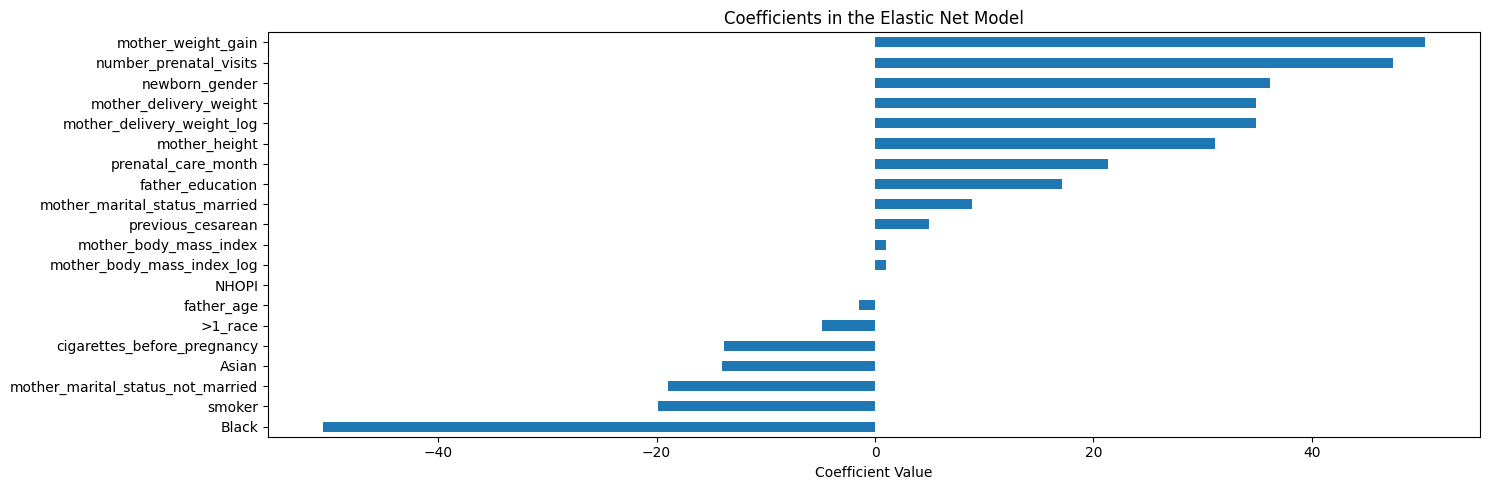

In [63]:
coef = run_elastic_net(df)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
fig, ax = plt.subplots(figsize=(15, 5))
imp_coef.plot(kind="barh", ax=ax)
ax.set_title("Coefficients in the Elastic Net Model")
ax.set_xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

In [64]:
coef = run_elastic_net(df)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

Elastic Net picked 20 variables and eliminated the other 1 variables


In [67]:
general_ranking = pd.merge(
    general_ranking,
    pd.DataFrame(imp_coef),
    left_index=True,
    right_index=True,
    how="left",
)

In [68]:
corr = list()
for i in x_col:
    corr.append(stats.spearmanr(df.loc[:, y_col].values, df.loc[:, i].values)[0])
    

In [69]:
general_ranking = pd.merge(
    general_ranking,
    pd.DataFrame(corr, index=x_col, columns=["corr"]),
    left_index=True,
    right_index=True,
)

In [70]:
pd.set_option("display.max_rows", 500)

In [71]:
general_ranking.sort_values(["mi_score","corr"], ascending=False)

,mi_score,sign_fscore,boruta_rank_x,boruta_rank_y,0,corr
mother_delivery_weight_log,0.037486,0.000000e+00,1,1,34.918590,0.209916
mother_delivery_weight,0.036013,0.000000e+00,1,1,34.922270,0.209916
number_prenatal_visits,0.025584,0.000000e+00,1,1,47.426143,0.148582
mother_weight_gain,0.019292,0.000000e+00,1,1,50.339909,0.173420
mother_height,0.015939,0.000000e+00,1,1,31.098036,0.157851
mother_body_mass_index,0.011893,0.000000e+00,1,1,0.981170,0.088949
mother_body_mass_index_log,0.010882,0.000000e+00,1,1,0.975618,0.088949
Black,0.010849,0.000000e+00,1,1,-50.526020,-0.134927
father_education,0.008544,0.000000e+00,3,3,17.102565,0.098974
newborn_gender,0.007798,0.000000e+00,1,1,36.148276,0.112589


In [72]:
import openpyxl


In [74]:
general_ranking.to_excel("../data/output/feature_ranking.xlsx")
df.to_csv("../data/output/train_fe.csv")
df_test.to_csv("../data/output/test_fe.csv")

